# 2D Diffusion Model

This models temperature diffusion over a two dimensional area. <br>

### Notes on Model Draft

Being a draft, there are many features that will be in the final version, that are not here yet.
- Adjusting grid cell size. Right now, the grid cell size is 1 meter. I plan to add an option to change the size of the grid cell.
- More complete plotting. Right now, plotting is minimal, and only plots the first and last timestep. I will add more plotting features, and figure out a way to show the temperature change over time. The tick marks are also unideal and look sloppy. I am not sure how to fix this, but I want to find a way to make the number of ticks adjustable depending on the size of the grid, and also look clean.
- Runge Kutta 4th order. As of right now, I couldn't get the runge kutta method to give correct numbers, so I used Euler's Method instead. This will be worked on as the Runge Kutta method will give more accuracy.
- Colormap. Right now, the colormap is not looking how I want. I'm still working on it. I want it to show a spectrum from blue to red, and clearly demonstrate temperature from the color of the plotted cell. I'm also working on a colorbar to show what each color maps to, but I haven't made a working version yet.
- Incoming solar radiation currently does not depend on time of day. I plan to add a feature that would change the incoming solar radiation depending on the time of day. This way, we could see a day night cycle. I have not done this yet.



### Input Information:
- Area: x_dimension and y_dimension take input in meters to create a grid.
- Grid cell size: takes input in meters.  Grid cells are square. x_dimension and y_dimension must be divisible by variable grid_cell_size
    (I haven't added this feature yet. Grid size is 1 meter. I plan to add this later)
- Initial temperatures: 2d numpy array for starting temperature at each grid cell.  Dimensions of initial temperature array must match the grid dimensions, or an error will be thrown.
- Boundary conditions: 'boundary' is a 2d numpy array who's outer ring will be the boundary layer for the area.
- Heat Capacity: 2d numpy array for heat capacity at each grid cell.
- End Time: in seconds. Multiply by constants 'HOURS', DAYS', 'MONTHS', OR 'YEARS' to make longer time periods readable. 

In [49]:
#standard library imports
from abc import ABC, abstractmethod
import subprocess


# third party imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
matplotlib.use('TkAgg')

"""Note about displaying animation: """

%matplotlib inline

In [50]:
class Constants:

    EARTH_RADIUS = 6.371E6  # in meters
    EMISSIVITY = 0.82
    STEFAN_BOLTZMANN_CONSTANT = 5.67E-8  # in W / m^2 / K^4

    SOLAR_IRRADIANCE = 1361 #units of W/m^2

    SILICON_SPECIFIC_HEAT = 712  # in J /kg / K
    SILICON_ROCK_DENSITY = 2650  # in kg/m^3
    WATER_SPECIFIC_HEAT = 4000  # in J /kg / K
    WATER_DENSITY = 1000  # in kg/m^3

    DAYS_PER_YEAR = 365.25
    HOURS_PER_DAY = 24
    SECONDS_PER_HOUR = 3600
    SECONDS_PER_DAY = HOURS_PER_DAY * SECONDS_PER_HOUR
    SECONDS_PER_YEAR = DAYS_PER_YEAR * SECONDS_PER_DAY

    # renamed for readability in naming end time
    DAYS = SECONDS_PER_DAY
    YEARS = SECONDS_PER_YEAR
    HOURS = SECONDS_PER_HOUR

    SOLAR_INSOLATION = 1361  # in W m-2
    DEGREES_TO_RADIANS = np.pi / 180.0

    EARTH_ALBEDO = 0.32

# Model Inputs

In [51]:
grid_x_dimension: int = 50
grid_y_dimension: int = 50

# grid_cell_size: float = 1

diffusion_coefficient = .1

# Format: (low temperature (inclusive), high temperature (exclusive), (shape))
initial_temperatures: np.ndarray = np.random.randint(225, 326, (grid_y_dimension, grid_x_dimension))


boundary: np.ndarray = np.full((grid_y_dimension+2, grid_x_dimension+2), 280)  # Constant boundary temperature of 280K

grid_cell_size = 1 # Please don't change this
silicon_heat_capacity = Constants.SILICON_SPECIFIC_HEAT * Constants.SILICON_ROCK_DENSITY * grid_cell_size # Also don't change this
water_heat_capacity = Constants.WATER_SPECIFIC_HEAT * Constants.WATER_DENSITY * grid_cell_size # Don't change this either
heat_capacity: np.ndarray = np.full((grid_y_dimension, grid_x_dimension), silicon_heat_capacity)

# makes a circular pond
heat_capacity[12, 15:19] = water_heat_capacity
heat_capacity[13, 13:21] = water_heat_capacity
heat_capacity[14:16, 12:22] = water_heat_capacity
heat_capacity[16:20, 11:23] = water_heat_capacity
heat_capacity[20:22, 12:22] = water_heat_capacity
heat_capacity[22, 13:21] = water_heat_capacity
heat_capacity[23, 15:19] = water_heat_capacity



#change the model timing
time_step: float = 1 * Constants.HOURS
num_steps: int = 500

In [52]:
class Grid:

    def __init__(self, x_dimension: int, y_dimension: int):

        self.x_dimension = x_dimension
        self.y_dimension = y_dimension

        self.midpoints = self.create_grid_midpoints()
        self.x_intersection_points, self.y_intersection_points = self.create_grid_interface_points()

        self.x_segment_length = self.midpoints[0, 1, 0] - self.midpoints[0, 0, 0]
        self.y_segment_length = self.midpoints[0, 0, 1] - self.midpoints[1, 0, 1]

        # Current temperatures including boundary cells
        self.current_temperatures = np.zeros((y_dimension + 2, x_dimension + 2))

        self.initial_temperatures = np.zeros((y_dimension + 2, x_dimension + 2))
        self.boundary = np.zeros((y_dimension + 2, x_dimension + 2))

        self.boundary_condition: str = ""
        self.heat_capacity: np.ndarray = np.zeros((y_dimension, x_dimension))

    def set_temperatures(self, temperatures: np.ndarray) -> None:
        """Sets the inside of the temperature array. Leaves the boundary unchanged

        Parameter 'temperatures' must be 2d numpy array of size (y_dimension, x_dimension)"""

        #check for correct dimension
        if not temperatures.shape == (self.y_dimension, self.x_dimension):
            print("In set_temperatures(), temperatures was not of the right shape")

        self.current_temperatures[1:-1, 1:-1] = temperatures

    def update_temperatures(self, temperature_change: np.ndarray) -> None:
        """Updates the current temperatures by adding input values 'temperature' to the current temperatures

            Parameter 'temperatures' must be a 2d numpy array with size (y_dimension, x_dimension)"""

        if not temperature_change.shape == (self.y_dimension, self.x_dimension):
            print("In update_temperatures(), temperatures was not of the correct shape.")

        self.current_temperatures[1:-1, 1:-1] += temperature_change

    def remove_boundary(self, temperatures: np.ndarray) -> np.ndarray:
        """Removes the boundary cells, and returns a 2d numpy array of size (y_dimension, x_dimension) containing the temperatures of the cells"""

        return temperatures[1:-1, 1:-1]

    def set_initial_temperatures(self, temperatures: np.ndarray) -> None:
        """Sets initial temperature based on a 2d numpy array passed in.
            temperatures must be a 2d numpy array with size [y_dimension, x_dimension]"""

        # check that input is the right size
        if not temperatures.shape == (self.y_dimension, self.x_dimension):
            print("Input of initial temperatures is not the correct shape.")

        self.current_temperatures[1:-1, 1:-1] = temperatures
        self.initial_temperatures[1:-1, 1:-1] = temperatures

    def set_boundary(self, boundary: np.ndarray) -> None:
        """Sets the boundary conditions. Input must be a 2d numpy array
            with size (y_dimension+2, x_dimension+2)"""

        # check that the input is the right size
        if not boundary.shape == (self.y_dimension + 2, self.x_dimension + 2):
            print("Input of boundary is not the correct shape.")

        self.current_temperatures[:, 0] = boundary[:, 0]
        self.current_temperatures[:, -1] = boundary[:, -1]
        self.current_temperatures[0, :] = boundary[0, :]
        self.current_temperatures[-1, :] = boundary[-1, :]

        self.boundary[:, 0] = boundary[:, 0]
        self.boundary[:, -1] = boundary[:, -1]
        self.boundary[0, :] = boundary[0, :]
        self.boundary[-1, :] = boundary[-1, :]

    def set_heat_capacity(self, heat_capacity: np.ndarray) -> None:
        """Takes in a 2d numpy array for what the heat capacity is at each cell."""

        # check that input is the right size
        if not heat_capacity.shape == (self.y_dimension, self.x_dimension):
            print(f"Heat Capacity array is the wrong size.")
            print(f"Grid dimension: ({self.y_dimension}, {self.x_dimension})")
            print(f"Heat capacity array: {heat_capacity.shape}")
            quit()

        self.heat_capacity = heat_capacity

    def create_grid_midpoints(self) -> np.ndarray:
        """Creates a grid storing coordinate points.  Includes coordinate points of the boundary."""

        # Check that dimensions are above zero
        if self.x_dimension <= 0 or self.y_dimension <= 0:
            print(f"Grid dimensions must be above zero.")

        # dimensions +2 to include the coordinates of the boundary cells
        grid_midpoints = np.zeros((self.y_dimension + 2, self.x_dimension + 2, 2))

        # fills the numpy array with coordinates of cell midpoints, including boundary cell midpoints
        for x_index in range(self.x_dimension + 2):
            grid_midpoints[:, x_index, 0] = x_index - (self.x_dimension + 1) / 2
            for y_index in range(self.y_dimension + 2):
                grid_midpoints[y_index, x_index, 1] = -1 * (y_index - (self.y_dimension + 1) / 2)

        return grid_midpoints

    def create_grid_interface_points(self) -> tuple[np.ndarray, np.ndarray]:
        """Creates two 2d numpy arrays.  One for coordinates of grid interface points on the x-axis,
            and one for grid interface points on the y-axis."""

        def create_x_interfaces() -> np.ndarray:

            grid_x_interfaces = np.zeros((self.y_dimension, self.x_dimension + 1, 2))

            for x_index in range(self.x_dimension + 1):
                grid_x_interfaces[:, x_index, 0] = x_index - (self.x_dimension / 2)

                for y_index in range(self.y_dimension):
                    grid_x_interfaces[y_index, x_index, 1] = -1 * (y_index - (self.y_dimension - 1) / 2)

            return grid_x_interfaces

        def create_y_interfaces() -> np.ndarray:

            grid_y_interfaces = np.zeros((self.y_dimension + 1, self.x_dimension, 2))

            for x_index in range(self.x_dimension):
                grid_y_interfaces[:, x_index, 0] = x_index - (self.x_dimension - 1) / 2

                for y_index in range(self.y_dimension + 1):
                    grid_y_interfaces[y_index, x_index, 1] = -1 * (y_index - (self.y_dimension / 2))

            return grid_y_interfaces

        return create_x_interfaces(), create_y_interfaces()



In [53]:
class DyDtEquation(ABC):
    """Parent class for first order differential equation of form \frac{dy}{dt} = f(t, y)"""

    @abstractmethod
    def __call__(self, t, y):
        pass


class Diffusion(DyDtEquation):

    def __init__(self, diffusion_coefficient: float, grid: Grid):
        self.diffusion_coefficient = diffusion_coefficient
        self.grid = grid

    def __call__(self, time: float, temperatures: np.ndarray) -> np.ndarray:
        """Calculates the temperature change in units of [units here] for each cell midpoint of the inputted array.

        Parameters
        ----------
        time: function does not depend on time, function only takes it for consistency, input a float of whatever
        temperatures: A 2d numpy array of temperature at each grid cell. Must include boundary."""

        def x_direction_diffusion(temperature: np.ndarray) -> np.ndarray:
            """Calculates temperature diffusion along the x-axis.  Returns a 2d numpy array
                of size (y_dimension, x_dimension) with values of diffusion (dT/dt) in units
                of [units here] for each grid midpoint position."""

            # temperature change across cells in the x direction
            dt_dx = (temperature[1:-1, 1:] - temperature[1:-1, :-1]) / self.grid.x_segment_length

            flux: np.ndarray = -1 * self.diffusion_coefficient * dt_dx

            incoming_shortwave_radiation = (Constants.SOLAR_IRRADIANCE / 4) * (1 - Constants.EARTH_ALBEDO)
            outgoing_longwave_radiation = (1 - Constants.EMISSIVITY / 2) * Constants.STEFAN_BOLTZMANN_CONSTANT * (
                    temperature[1:-1, 1:-1] ** 4)
            flux_derivative = (flux[:, 1:] - flux[:, :-1]) / self.grid.x_segment_length

            x_direction_diffusion = ((incoming_shortwave_radiation - outgoing_longwave_radiation - flux_derivative) /
                                     self.grid.heat_capacity)

            return x_direction_diffusion

        def y_direction_diffusion(temperature: np.ndarray) -> np.ndarray:
            """Calculates temperature diffusion along the y-axis.  Returns a 2d numpy array
            of size (y_dimension, x_dimension) with values of diffusion (dT/dt) in units
            of [units here] for each grid midpoint position."""

            # temperature change across cells in the y direction
            dt_dy = (temperatures[1: , 1:-1] - temperatures[:-1, 1:-1]) / self.grid.y_segment_length

            flux: np.ndarray = -1 * self.diffusion_coefficient * dt_dy

            incoming_shortwave_radiation = (Constants.SOLAR_IRRADIANCE / 4) * (1 - Constants.EARTH_ALBEDO)
            outgoing_longwave_radiation = ((1 - Constants.EMISSIVITY / 2) * Constants.STEFAN_BOLTZMANN_CONSTANT *
                                           (temperatures[1:-1, 1:-1] ** 4))
            flux_derivative = (flux[1:, :] - flux[:-1, :]) / self.grid.y_segment_length

            x_direction_diffusion = ((incoming_shortwave_radiation - outgoing_longwave_radiation - flux_derivative) /
                                     self.grid.heat_capacity)

            return x_direction_diffusion

        return x_direction_diffusion(temperatures) + y_direction_diffusion(temperatures)


In [54]:
def area_runge_kutta_calculator(grid: Grid, function: DyDtEquation, time_step: float, num_steps: int) -> np.ndarray:
    """Uses the 4th order runge kutta method to solve a differential equation over an area that includes a boundary.

        Parameters:
        -----------
        grid: Grid object
        function: 1st order differential equation of type DyDtEquation. returns 2d numpy array of (dT/dt) at each grid cell midpoint
        initial_values: 2d numpy array with size (y_dimension, x_dimension) containing the initial value of what we are calculating at each grid cell
        time_step: float, length of the time step in seconds
        num_steps: int, how many steps to take"""

    time = 0
    y_values: np.ndarray = np.zeros((grid.y_dimension + 2, grid.x_dimension + 2, num_steps + 1))
    y_values[:, :, 0] = grid.current_temperatures

    for step in range(1, num_steps + 1):

        k1: np.ndarray = function(time, grid.current_temperatures)

        intermediate_temperature_storage: np.ndarray = grid.current_temperatures.copy()
        intermediate_temperature_storage[1:-1, 1:-1] += time_step *(k1[1:-1, 1:-1]/2)

        k2: np.ndarray = function((time + .5*time_step), intermediate_temperature_storage)

        intermediate_temperature_storage: np.ndarray = grid.current_temperatures.copy()
        intermediate_temperature_storage[1:-1, 1:-1] += time_step * (k2[1:-1, 1:-1] / 2)

        k3: np.ndarray = function((time + .5*time_step), (grid.current_temperatures + k2*(time_step/2)))

        intermediate_temperature_storage: np.ndarray = grid.current_temperatures.copy()
        intermediate_temperature_storage[1:-1, 1:-1] += time_step * k2[1:-1, 1:-1]

        k4: np.ndarray = function((time + time_step), (grid.current_temperatures + k3*time_step))

        temperature_change = (grid.current_temperatures * (1/6) * (k1 + 2*k2 + 2*k3 + k4) * time_step)

        grid.update_temperatures(grid.remove_boundary(temperature_change))

        y_values[:, :, step] = grid.current_temperatures

    return y_values

def area_euler_method_calculator(grid: Grid, function: DyDtEquation, time_step: float, num_steps: int) -> np.ndarray:
    
    time = 0
    y_values: np.ndarray = np.zeros((grid.y_dimension+2, grid.x_dimension+2, num_steps + 1))
    y_values[:, :, 0] = grid.current_temperatures.copy()
    
    for step in range(1, num_steps+1):
        
        next_y_values = grid.current_temperatures[1:-1, 1:-1] + time_step*function(time, grid.current_temperatures)
        
        grid.set_temperatures(next_y_values)
        y_values[:, :, step] = grid.current_temperatures
        
    
    return y_values   

In [55]:
# Create the grid
grid = Grid(grid_x_dimension, grid_y_dimension)

grid.set_initial_temperatures(initial_temperatures)
grid.set_boundary(boundary)
grid.set_heat_capacity(heat_capacity)

#initialized the diffusion equation
diffusion = Diffusion(diffusion_coefficient, grid)

time_stepped_temperatures = area_euler_method_calculator(grid, diffusion, time_step, num_steps)



# Plotting

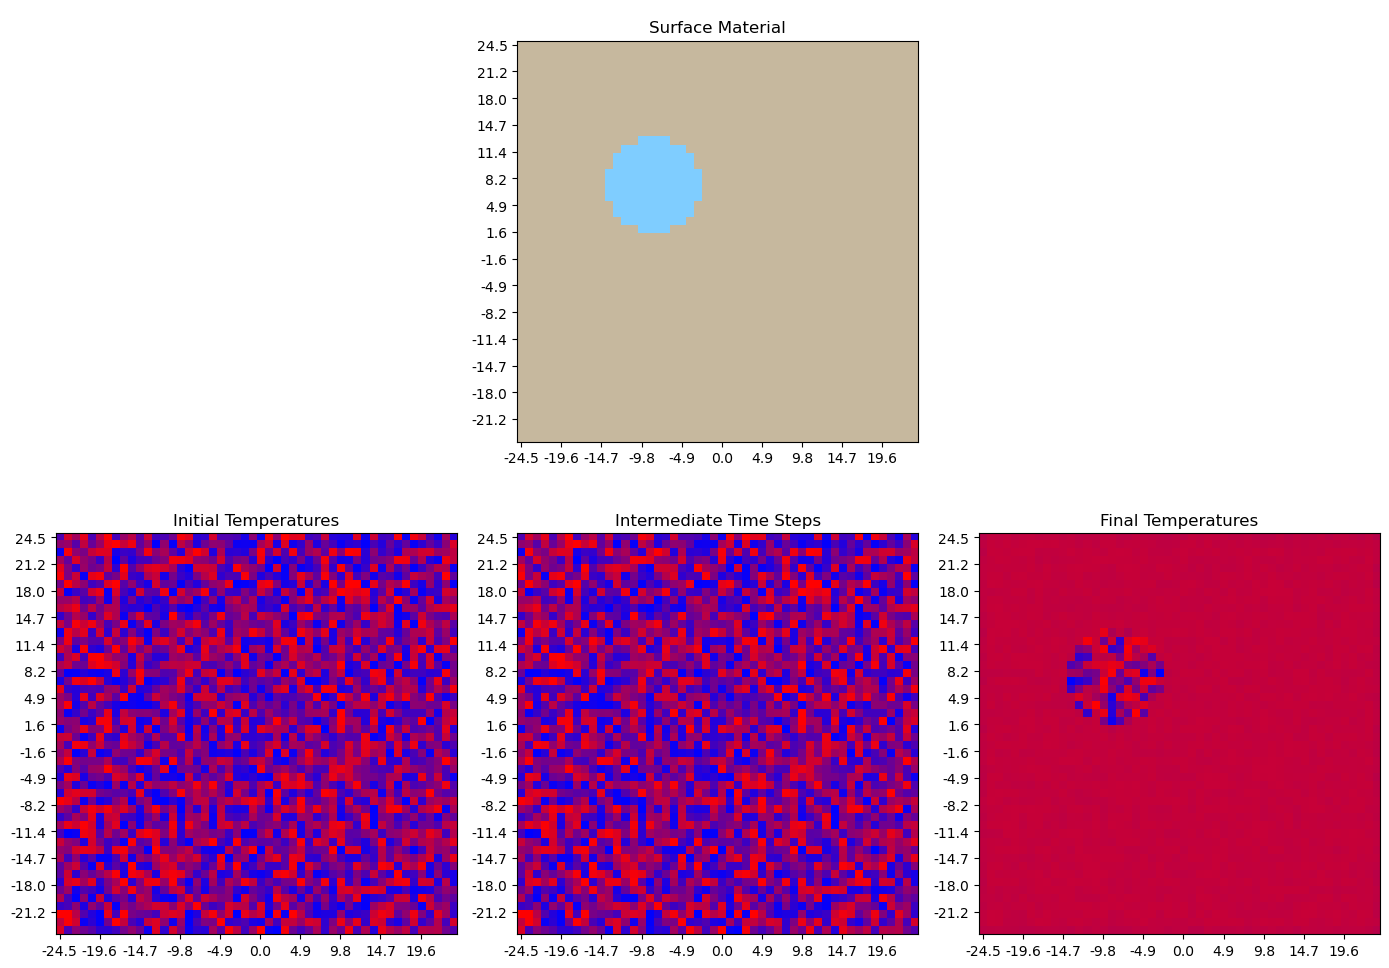

In [57]:
num_x_ticks: int = 11
num_y_ticks: int = 16
x_axis: np.ndarray = np.round(np.linspace((-1 * (grid_x_dimension - 1) / 2), (grid_x_dimension - 1) / 2, num_x_ticks),
                              1)
y_axis: np.ndarray = np.round(np.linspace((grid_y_dimension - 1) / 2, -1 * (grid_y_dimension - 1) / 2, num_y_ticks), 1)
x_axis_tick_locations: np.ndarray = np.linspace(0, grid_x_dimension, num_x_ticks)
y_axis_tick_locations: np.ndarray = np.linspace(0, grid_y_dimension, num_y_ticks)

x_coordinates, y_coordinates = np.meshgrid(x_axis, y_axis)

temperature_color_map = LinearSegmentedColormap.from_list("blue_red", ["#0000FF", "#FF0000"])
heat_capacity_colors = ListedColormap(['#C6B89E', '#7fcdff'])
bounds = [water_heat_capacity, silicon_heat_capacity]
normalize_heat_capacity_colors = plt.Normalize(vmin=min(bounds), vmax=max(bounds))

fig, ax = plt.subplots(2, 3, figsize=(14, 10))

for subplot in ax.flat:
    subplot.set_xticks((x_axis_tick_locations))
    subplot.set_xticklabels(x_axis)
    subplot.set_yticks(y_axis_tick_locations)
    subplot.set_yticklabels(y_axis)

ax[0, 0].axis('off')
ax[0, 2].axis('off')

#plot the heat capacity
ax[0, 1].imshow(grid.heat_capacity, cmap=heat_capacity_colors, norm=normalize_heat_capacity_colors)
ax[0, 1].set_title("Surface Material")


#plot initial temperatures
initial_temperatures_plot = ax[1, 0].imshow(grid.remove_boundary(grid.initial_temperatures), cmap=temperature_color_map)
ax[1, 0].set_title("Initial Temperatures")

temperature_graph = ax[1, 1].imshow(grid.remove_boundary(time_stepped_temperatures[:, :, 0]), cmap=temperature_color_map)
ax[1, 1].set_title("Intermediate Time Steps")

# Function to update the image for each frame
def update(frame):
    temperature_graph.set_array(grid.remove_boundary(time_stepped_temperatures[:, :, frame]))
    return [temperature_graph]

# Create the animation
temperature_animation = FuncAnimation(fig, update, frames=num_steps, interval=.01, blit=True)


#plot final temperatures
final_temperatures_plot = ax[1, 2].imshow(grid.remove_boundary(time_stepped_temperatures[:, :, -1]), cmap=temperature_color_map)
ax[1, 2].set_title("Final Temperatures")

plt.tight_layout()
plt.show()